In [95]:
import warnings
warnings.filterwarnings('ignore')

In [96]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)

from sklearn.model_selection import train_test_split,cross_val_score,KFold,RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix,precision_recall_curve,precision_score,recall_score
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB,GaussianNB
from mlxtend.classifier import StackingClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output

Get rid of the decade data which, though interesting, is not mega useful for a model because you can't control that.

In [97]:
aud_table = pd.read_pickle('aud_edad.pkl')
aud_table = aud_table.drop(['decade_old','decade_80s','decade_70s','decade_90s'],axis=1)

Create a holdout.

In [98]:
train,test = train_test_split(aud_table,shuffle=True,test_size=.2,random_state=8)
kf = KFold(n_splits=4,shuffle=True,random_state=8)

In [99]:
X = train.drop(['audience'],axis=1)
y = train['audience']

### Check for Balance
Now that's what I call a balanced distribution between train/test

In [6]:
len(test[test.audience==1])/len(test)

0.5456595264937993

In [7]:
len(train[train.audience==1])/len(train)

0.5531435015506061

In [8]:
len(aud_table[aud_table.audience==1])/len(aud_table)

0.5516463689670726

### Naive classifiers to test against class-balanced data

In [9]:
rf = RandomForestClassifier(n_estimators=100,random_state=8,max_depth=11)
cross_val_score(rf,X,y,scoring='accuracy',cv=kf).mean()

0.6935433691063035

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
lr = LogisticRegression(solver='lbfgs',random_state=8)
cross_val_score(lr,X_scaled,y,scoring='accuracy',cv=kf).mean()

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0.6698613786802599

### Balanced data results
It looks like oversampling is not the worst idea from the results of this section, so let's do it!

In [11]:
len(X[y==0])

1585

In [12]:
len(X[y==1])

1962

Oversampling class 1.

In [13]:
from imblearn.over_sampling import SMOTE
Xb, yb = SMOTE(random_state=8,sampling_strategy={0:1962,1:1962}).fit_sample(X,y)

In [14]:
rf = RandomForestClassifier(n_estimators=100,random_state=8,max_depth=11)
cross_val_score(rf,Xb,yb,scoring='accuracy',cv=kf).mean()

0.7130479102956169

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xb)
lr = LogisticRegression(solver='lbfgs',random_state=8)
cross_val_score(lr,X_scaled,yb,scoring='accuracy',cv=kf).mean()

0.6758409785932722

Undersampling class 0.

In [16]:
from imblearn.under_sampling import RandomUnderSampler
Xb, yb = RandomUnderSampler(random_state=42,ratio={0:1585,1:1585}).fit_sample(X,y)

In [17]:
rf = RandomForestClassifier(n_estimators=100,random_state=8,max_depth=11)
cross_val_score(rf,Xb,yb,scoring='accuracy',cv=kf).mean()

0.6823408262957443

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xb)
lr = LogisticRegression(solver='lbfgs',random_state=8)
cross_val_score(lr,X_scaled,yb,scoring='accuracy',cv=kf).mean()

0.6675085501929764

In [100]:
Xb, yb = SMOTE(random_state=8,sampling_strategy={0:1962,1:1962}).fit_sample(X,y)
Xb = pd.DataFrame(Xb)
Xb.columns = X.columns

# Models

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xb)

### SVM
I didn't run in this notebook because again, SVMs are cool but honestly the worst to actually use.

### Random Forest
Best precision : 72% <br />
Best recall : 72%

In [101]:
rf_params = {'criterion':['gini','entropy'],'max_depth':list(range(1,23))}

In [23]:
rf_gridsearch = RandomForestClassifier(n_estimators=100,random_state=8)
rando = RandomizedSearchCV(rf_gridsearch,param_distributions=rf_params,n_iter=40,scoring='precision',
                               random_state=8,cv=kf)
rando = rando.fit(Xb,yb)
rando.best_params_

{'max_depth': 15, 'criterion': 'entropy'}

In [102]:
rf = RandomForestClassifier(random_state=8,n_estimators=100,criterion='entropy',max_depth=15)
print(cross_val_score(rf,Xb,yb,scoring='precision',cv=kf).mean())
print(cross_val_score(rf,Xb,yb,scoring='recall',cv=kf).mean())

0.7191724729453812
0.7223348402458644


In [103]:
rf.fit(Xb,yb)
sorted(list(zip(X.columns,rf.feature_importances_)), key = lambda x : x[1])

[('Sport', 0.00669392405649311),
 ('War', 0.007019951493716034),
 ('History', 0.007355352077487883),
 ('Music', 0.008248455359865004),
 ('Musical', 0.010150077889159394),
 ('language_andre', 0.010264228305952132),
 ('rating_andre', 0.010266039018903154),
 ('country_UK', 0.012783824319784878),
 ('aspect_ratio_other', 0.014156382072639771),
 ('Documentary', 0.016709315084051365),
 ('Biography', 0.019967082587254662),
 ('Horror', 0.03870344015050804),
 ('starpower', 0.07363963690548203),
 ('Drama', 0.09087625183369843),
 ('actor_1_fb', 0.09466973409687719),
 ('actor_2_fb', 0.09798076859484948),
 ('actor_3_fb', 0.09970682591551476),
 ('director_fb', 0.10755145202686918),
 ('budget', 0.12245670395039601),
 ('runtime', 0.15080055426049752)]

As we see in the next two cells, dropping the least important feature does change things, but it increases recall instead of precision so we don't stick with this.

In [25]:
rf_gridsearch = RandomForestClassifier(n_estimators=100,random_state=8)
rando = RandomizedSearchCV(rf_gridsearch,param_distributions=rf_params,n_iter=40,scoring='precision',
                               random_state=8,cv=kf)
rando = rando.fit(Xb.drop(['Sport'],axis=1),yb)
rando.best_params_

{'max_depth': 16, 'criterion': 'gini'}

In [26]:
rf = RandomForestClassifier(random_state=8,n_estimators=100,criterion='gini',max_depth=16)
print(cross_val_score(rf,X.drop('Sport',axis=1),y,scoring='precision',cv=kf).mean())
print(cross_val_score(rf,X.drop('Sport',axis=1),y,scoring='recall',cv=kf).mean())

0.7045769728705715
0.7449059441294067


### Moving on...
Here I get rid of 'musical' (the 15th most important). Still little change, so we'll keep our first model.

In [105]:
rf_gridsearch = RandomForestClassifier(n_estimators=100,random_state=8)
rando = RandomizedSearchCV(rf_gridsearch,param_distributions=rf_params,n_iter=40,scoring='precision',
                               random_state=8,cv=kf)
rando = rando.fit(X.drop(['Musical'],axis=1),y)
rando.best_params_

{'max_depth': 12, 'criterion': 'entropy'}

In [106]:
rf = RandomForestClassifier(random_state=8,n_estimators=100,criterion='entropy',max_depth=17)
print(cross_val_score(rf,X.drop(['language_andre'],axis=1),y,scoring='precision',cv=kf).mean())
print(cross_val_score(rf,X.drop(['language_andre'],axis=1),y,scoring='recall',cv=kf).mean())

0.7094341720879451
0.7490674338179024


### KNeighbours
High precision : .86,.09
Min recall : .75,.35

In [30]:
knn_params = {'n_neighbors':list(range(1,1501)),'weights':['uniform','distance']}

In [34]:
knn_gridsearch = KNeighborsClassifier()
rando = RandomizedSearchCV(knn_gridsearch,param_distributions=knn_params,n_iter=100,scoring='precision',
                               random_state=8,cv=kf)
rando = rando.fit(X_scaled,yb)
rando.best_params_

{'weights': 'uniform', 'n_neighbors': 1216}

In [36]:
knn = KNeighborsClassifier(n_neighbors=1216,weights='uniform')
print(cross_val_score(knn,X_scaled,yb,scoring='precision',cv=kf).mean())
print(cross_val_score(knn,X_scaled,yb,scoring='recall',cv=kf).mean())

0.8610067016317017
0.08826645618511347


Test the various neighbors to try to narrow down where it crosses the acceptable threshhold.

In [38]:
precisions = []
recalls = []
for i in range(1,1502,10) :
    clear_output()
    print(i)
    knn=KNeighborsClassifier(n_neighbors=i,weights='uniform')
    precisions.append(cross_val_score(knn,X_scaled,yb,scoring='precision',cv=kf))
    recalls.append(cross_val_score(knn,X_scaled,yb,scoring='recall',cv=kf))

1501


In [39]:
p_means = [x.mean() for x in precisions]
r_means = [x.mean() for x in recalls]

In [107]:
plt.plot(r_means,p_means)
plt.plot([0,.67],[.67,.67])
plt.plot([.35,.35],[.5,1])
plt.legend()

SyntaxError: invalid syntax (<ipython-input-107-b3f21b86f8ca>, line 1)

Further narrowing down the location of the minimum acceptable recall.

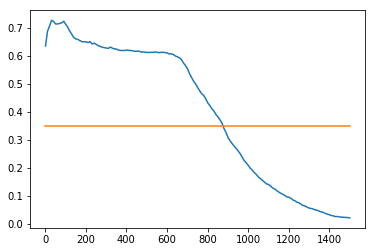

In [41]:
plt.plot(list(range(1,1502,10)),r_means,label='recall')
plt.plot([0,1501],[.35,.35]);

In [44]:
prec = 1000
recall = 1000
neighbors = 1000
for i in range(825,925) :
    knn=KNeighborsClassifier(n_neighbors=i,weights='uniform')
    recall_t = cross_val_score(knn,X_scaled,yb,scoring='recall',cv=kf).mean()
    if recall_t >= .35 :
        prec = cross_val_score(knn,X_scaled,yb,scoring='precision',cv=kf).mean()
        recall = cross_val_score(knn,X_scaled,yb,scoring='recall',cv=kf).mean()
        neighbors=i
    elif recall<.35 :
        break

Now that we have found the minimum (or near minimum) pair for recall, how many neighbours was that?

In [45]:
neighbors

873

In [47]:
knn = KNeighborsClassifier(n_neighbors=neighbors,weights='uniform')
print(cross_val_score(knn,X_scaled,yb,scoring='precision',cv=kf).mean())
print(cross_val_score(knn,X_scaled,yb,scoring='recall',cv=kf).mean())

0.751164100495157
0.3560196767882029


### Logistic Regression
Precision = .68 <br />
Recall = .64

In [48]:
lr_params = {'solver':['saga','lbfgs'],'C':np.linspace(1e-7,100,101),'tol':np.linspace(1e-7,100,101)}

In [50]:
lr_gridsearch = LogisticRegression(random_state=8)
rando = RandomizedSearchCV(lr_gridsearch,param_distributions=lr_params,n_iter=100,scoring='precision',
                               random_state=8,cv=kf)
rando.fit(X_scaled,yb)
rando.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'tol': 35.000000065, 'solver': 'saga', 'C': 91.00000000899999}

In [51]:
lr = LogisticRegression(tol=35,C=91,solver='saga',random_state=8)
print(cross_val_score(lr,X_scaled,yb,scoring='precision',cv=kf).mean())
print(cross_val_score(lr,X_scaled,yb,scoring='recall',cv=kf).mean())

0.6829113072846226
0.6454386992108354


In [52]:
lr.fit(X_scaled,yb)
sorted(list(zip(X.columns,lr.coef_[0])),key = lambda x : x[1])

[('Horror', -0.20748488576471055),
 ('budget', -0.007799287703383429),
 ('actor_2_fb', 0.015768441881767747),
 ('actor_3_fb', 0.01783228475568693),
 ('starpower', 0.050351539437688254),
 ('aspect_ratio_other', 0.05504589474284338),
 ('actor_1_fb', 0.05729728588520348),
 ('country_UK', 0.061409228351168306),
 ('History', 0.07169742899213585),
 ('rating_andre', 0.07336969050616036),
 ('Sport', 0.0853723901721629),
 ('language_andre', 0.08724912772792352),
 ('War', 0.0982267368394145),
 ('Music', 0.10378711514365856),
 ('director_fb', 0.10912099580475),
 ('Biography', 0.10970236186146079),
 ('Musical', 0.11643222978146776),
 ('Documentary', 0.1589595330224248),
 ('runtime', 0.21567806246155904),
 ('Drama', 0.2467224985957975)]

Here I try dropping the least impactful feature, as rated above. I did this for a few of the lowest ones and found that they all failed to increase the precision and lowered the accuracy, so this is not a good change.

In [54]:
X_dropping = Xb.drop(['Horror'],axis=1)
X_scaled_dropping = scaler.fit_transform(X_dropping)

In [55]:
lr_gridsearch = LogisticRegression(random_state=8)
rando = RandomizedSearchCV(lr_gridsearch,param_distributions=lr_params,n_iter=100,scoring='precision',
                               random_state=8,cv=kf)
rando.fit(X_scaled_dropping,yb)
rando.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'tol': 35.000000065, 'solver': 'saga', 'C': 91.00000000899999}

In [56]:
lr = LogisticRegression(tol=35,C=91,solver='saga',random_state=8)
print(cross_val_score(lr,X_scaled_dropping,yb,scoring='precision',cv=kf).mean())
print(cross_val_score(lr,X_scaled_dropping,yb,scoring='recall',cv=kf).mean())

0.6905236839345382
0.5975294094672485


### Naive Bayes (Bernoulli)
Precision = .68 <br />
Recall = .34

In [22]:
nbb = BernoulliNB()
print(cross_val_score(nbb,Xb.loc[:,['Documentary','Biography','History','Musical','Sport','language_andre','country_UK',
                                    'Horror']],yb,scoring='precision',cv=kf).mean())
print(cross_val_score(nbb,Xb.loc[:,['Documentary','Biography','History','Musical','Sport','language_andre','country_UK',
                                    'Horror']],yb,scoring='recall',cv=kf).mean())

0.6798548599886653
0.33706111988916687


### Naive Bayes (Gaussian)
Precision = .68 <br />
Recall = .33

In [23]:
X_selection = Xb.loc[:,['runtime','actor_2_fb']]
X_scaled = scaler.fit_transform(X_selection)
nbg = GaussianNB()
print(cross_val_score(nbg,X_scaled,yb,scoring='precision',cv=kf).mean())
print(cross_val_score(nbg,X_scaled,yb,scoring='recall',cv=kf).mean())

0.6770945759312742
0.3267150330541616


### Naive Bayes (Ensembled)
Now to combine the two! The best method, we see, is weighted soft voting for a balance of recall and precision.

In [25]:
nbg.fit(Xb.loc[:,['runtime','actor_2_fb']],yb)
nbb.fit(Xb.loc[:,['Documentary','Biography','History','Musical','Sport','language_andre','country_UK','Horror']],yb)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [26]:
X_scaled = scaler.fit_transform(Xb)
estimators = [('nbg',nbg),('nbb',nbb)]
nb_vote = VotingClassifier(estimators=estimators,voting='hard')
print(cross_val_score(nb_vote,X_scaled,yb,scoring='precision',cv=kf).mean())
print(cross_val_score(nb_vote,X_scaled,yb,scoring='recall',cv=kf).mean())

0.7480918569748028
0.385352689814506


In [27]:
X_scaled = scaler.fit_transform(Xb)
estimators = [('nbg',nbg),('nbb',nbb)]
nb_vote = VotingClassifier(estimators=estimators,weights=[.25,.5],voting='soft')
print(cross_val_score(nb_vote,X_scaled,yb,scoring='precision',cv=kf).mean())
print(cross_val_score(nb_vote,X_scaled,yb,scoring='recall',cv=kf).mean())

0.7004163170759126
0.47820013845329046


In [28]:
nb_stack = StackingClassifier(classifiers=[nbg],meta_classifier=nbb)
print(cross_val_score(nb_stack,X_scaled,yb,scoring='precision',cv=kf).mean())
print(cross_val_score(nb_stack,X_scaled,yb,scoring='recall',cv=kf).mean())

0.7015078968790767
0.42923923011345333


### AT THIS POINT
The best models up to now are listed below.

Og så kan vi ser om (and so we can see if) mixing the models is better! And ultimately, yes in the case of a voting classifier (though it comes at the cost of recall). No matter what I tried with stacking, though, there was no improvement.

In [30]:
from sklearn.ensemble import VotingClassifier
from mlxtend.classifier import StackingClassifier

In [31]:
X_scaled = scaler.fit_transform(Xb)

In [32]:
rf = RandomForestClassifier(random_state=8,n_estimators=100,criterion='entropy',max_depth=15)
knn = KNeighborsClassifier(n_neighbors=873,weights='uniform')
estimators = [('nbg',nbg),('nbb',nbb)]
nb = VotingClassifier(estimators=estimators,weights=[.25,.5],voting='soft')
lr = LogisticRegression(tol=35,C=91,solver='saga',random_state=8)
knn_hp = KNeighborsClassifier(n_neighbors=1216,weights='uniform')

In [33]:
final_estimators = [('rf',rf),
             ('knn',knn),
             ('nb',nb),
             ('lr',lr)]

In [34]:
vclass = VotingClassifier(estimators=final_estimators,voting='hard')
print(cross_val_score(vclass,X_scaled,yb,scoring='precision',cv=kf).mean())
print(cross_val_score(vclass,X_scaled,yb,scoring='recall',cv=kf).mean())

0.7548791368183193
0.4644929549299318


In [35]:
final_estimators = [('rf',rf),
             ('knn',knn),
             ('knn_hp',knn_hp)]

In [36]:
vclass = VotingClassifier(estimators=final_estimators,weights=[3,2,2],voting='soft')
print(cross_val_score(vclass,X_scaled,yb,scoring='precision',cv=kf).mean())
print(cross_val_score(vclass,X_scaled,yb,scoring='recall',cv=kf).mean())

0.7576976975738022
0.6112625597857646


In [37]:
estimators = [rf,knn_hp,nb]

In [38]:
sclass = StackingClassifier(classifiers=estimators,
                            meta_classifier=knn_hp,
                            use_probas=True)
print(cross_val_score(sclass,X_scaled,yb,scoring='precision',cv=kf).mean())
print(cross_val_score(sclass,X_scaled,yb,scoring='recall',cv=kf).mean())

0.7132071727962711
0.7294758359070116


In [39]:
estimators = [rf,knn_hp]

In [40]:
sclass = StackingClassifier(classifiers=estimators,
                            meta_classifier=rf,
                            use_probas=False)
print(cross_val_score(sclass,X_scaled,yb,scoring='precision',cv=kf).mean())
print(cross_val_score(sclass,X_scaled,yb,scoring='recall',cv=kf).mean())

0.7207350411283496
0.7228533837396405


### NOW TO DECIDE 
And it's easy this time! 72/72 - the second stacker.

In [41]:
estimators = [rf,knn_hp]

In [42]:
final_mod = StackingClassifier(classifiers=estimators,
                            meta_classifier=rf,
                            use_probas=False,
                            store_train_meta_features=True)
final_mod.fit(X_scaled,yb)
print(cross_val_score(sclass,X_scaled,yb,scoring='precision',cv=kf).mean())
print(cross_val_score(sclass,X_scaled,yb,scoring='recall',cv=kf).mean())

0.7207350411283496
0.7228533837396405


Let's test this on our test data - pretty good!

In [43]:
from sklearn.metrics import precision_score,recall_score

In [44]:
X_t = test.drop('audience',axis=1)
scaler.fit(Xb)
X_t_scaled = scaler.transform(X_t)
y_t = test['audience']
y_pred = final_mod.predict(X_t_scaled)

print(precision_score(y_t,y_pred))
print(recall_score(y_t,y_pred))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


0.7262931034482759
0.6962809917355371


Visualising the confusion matrix.

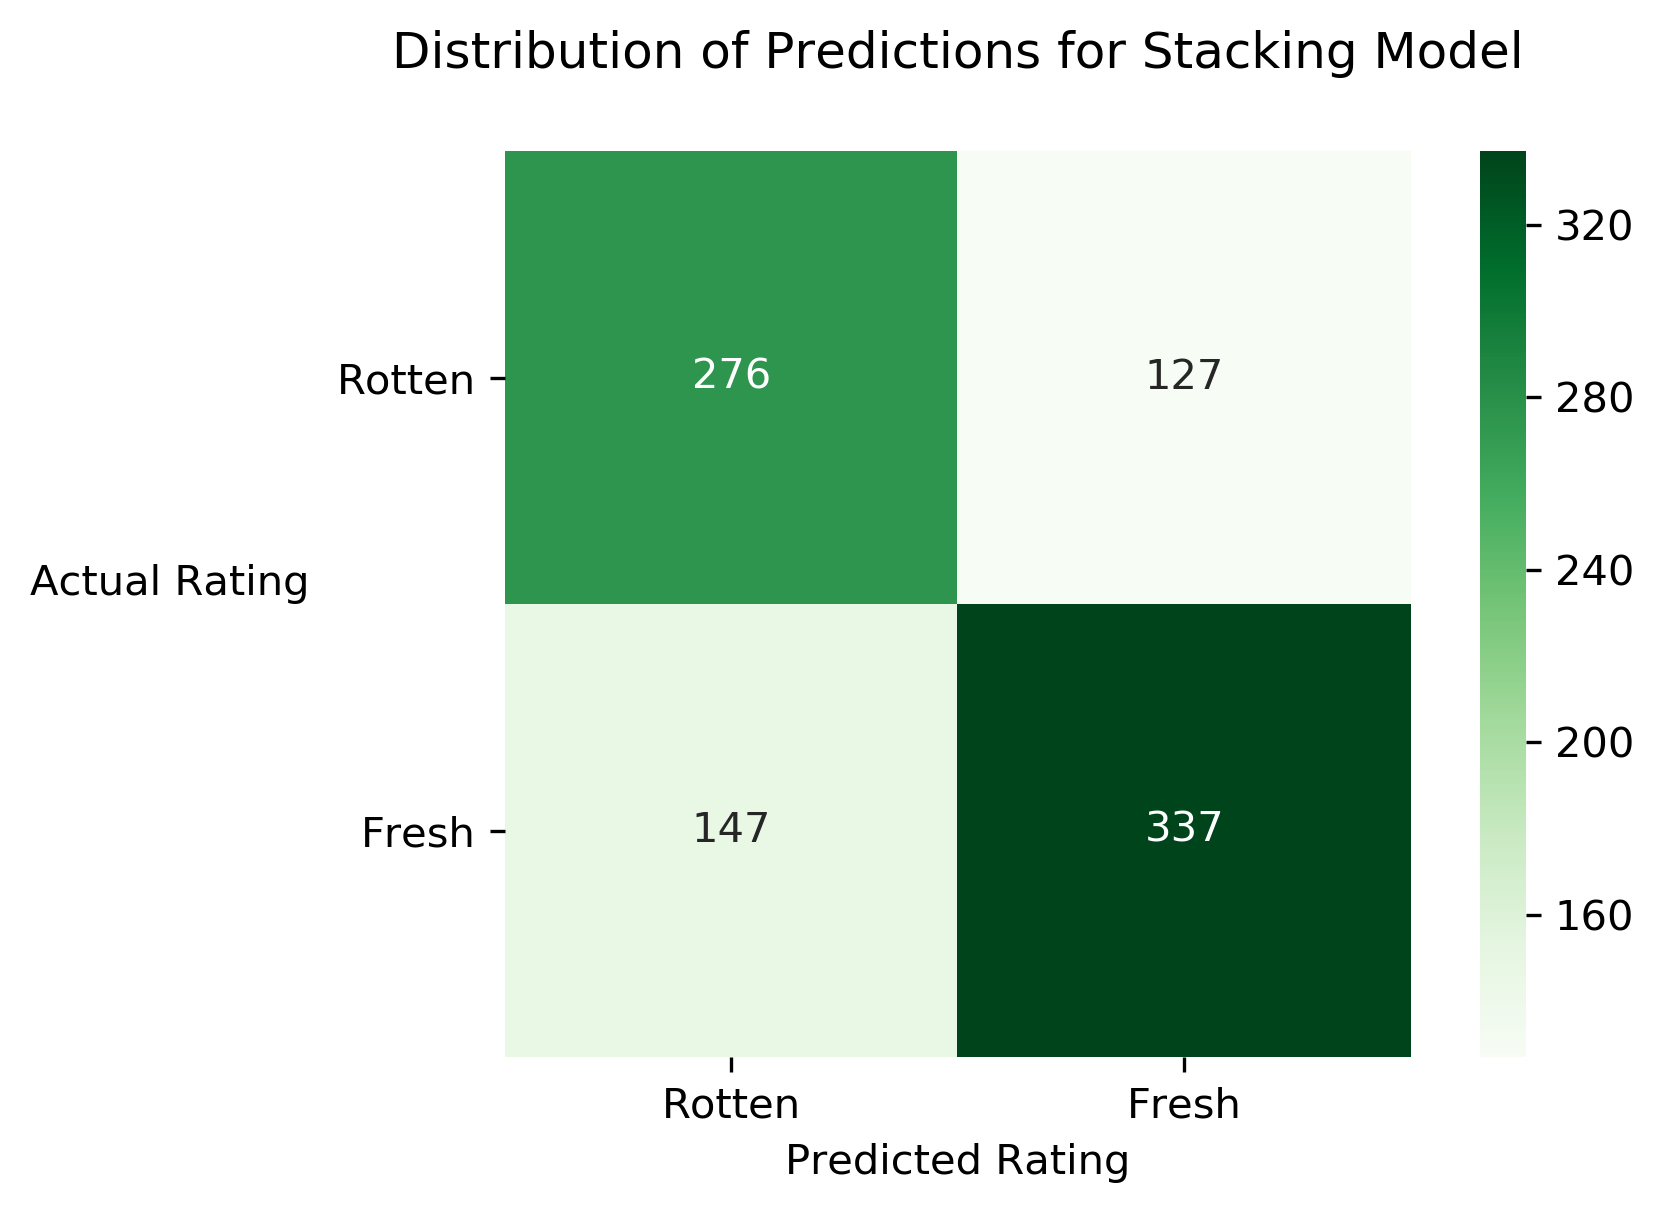

In [45]:
plt.figure(dpi=300)
ax = sns.heatmap(confusion_matrix(y_t,y_pred),cmap=plt.cm.Greens,
            annot=True,
            fmt='g',
            annot_kws = {'size':10},
            square=True,
            xticklabels=['Rotten','Fresh'],
            yticklabels=['Rotten','Fresh'],
                )
ax.set_yticklabels(ax.get_yticklabels(),rotation=360)
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating',rotation=360,labelpad=40)
plt.title('Distribution of Predictions for Stacking Model',pad=20)
plt.savefig('confusion_aud.svg');

Save everything!

In [57]:
import pickle

In [58]:
with open("final_aud.pkl", "wb") as f:
    pickle.dump(final_mod, f)

In [59]:
with open("aud_scaler.pkl","wb") as f :
    pickle.dump(scaler,f)